Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

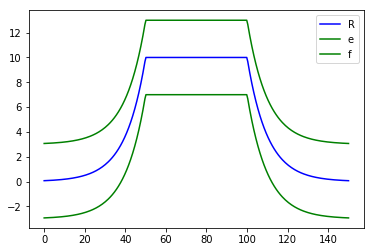

In [7]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [1, 1]
q2 = [.5, .5]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])


Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [8]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0][:]  # Initial state.
# Random initial action path.
#us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
us_init = np.zeros((H - 1, dynamics.action_size))

for i in range(0, int(N - H) + 1):
    k = 1
    if i % k != 0:
        continue
        #pass
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]



iteration 0 accepted [ 0.09824598] [ 14.50788224   0.26186023  10.00792706   0.01951575] [-0.00054936 -0.00319479]


/home/gaoruihan/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 0 accepted [ 0.10847882] [ 15.00880954   0.27697768  10.00853992   0.01992141] [-0.00056954 -0.00386937]
iteration 0 accepted [ 0.11923221] [ 15.50978409   0.29170297  10.00915954   0.02079085] [-0.00059059 -0.00419818]
iteration 0 accepted [ 0.13073056] [ 16.01079476   0.30657182  10.00978244   0.02193298] [-0.00061226 -0.00434885]
iteration 0 accepted [ 0.14321806] [ 16.51182512   0.32195301  10.01040119   0.02322244] [-0.00063394 -0.00443172]
iteration 0 accepted [ 0.1568994] [ 17.01286284   0.33808076  10.01101079   0.02458772] [-0.00065521 -0.00451082]
iteration 0 accepted [ 0.17194401] [ 17.51390018   0.35509419  10.01160904   0.02599548] [-0.00067589 -0.0046176 ]
iteration 0 accepted [ 0.1885038] [ 18.01493219   0.37307285  10.01219549   0.02743628] [-0.00069595 -0.0047632 ]
iteration 0 accepted [ 0.20672864] [ 18.5159552    0.39206424  10.0127705    0.02891379] [-0.00071541 -0.00494778]
iteration 0 accepted [ 0.22677684] [ 19.01696596   0.41210251  10.01333482   0.030

iteration 0 accepted [ 154.72081822] [ 50.41025415   7.4144692   10.23558356   0.15017181] [-0.01166449  0.02693497]
iteration 0 accepted [ 165.97572852] [ 50.89129834   7.62275594  10.25107409   0.16332565] [-0.01241464  0.02691208]
iteration 0 accepted [ 176.03063595] [ 51.37291039   7.83346483  10.26675049   0.1771957 ] [-0.01318233  0.0267785 ]
iteration 0 accepted [ 181.78962071] [ 51.81590573   8.15213992  10.29248437   0.18718206] [-0.01458323  0.03187212]
iteration 0 accepted [ 194.04714452] [ 52.34649647   8.21846275  10.29774422   0.1916444 ] [-0.01464655  0.02992981]
iteration 0 accepted [ 203.48024713] [ 52.84994513   8.3534685   10.30873187   0.19252496] [-0.01511107  0.0319963 ]
iteration 0 accepted [ 211.50629844] [ 53.3436839    8.50169629  10.32216621   0.188326  ] [-0.01573194  0.03720138]
iteration 0 accepted [ 219.87322656] [ 53.84594612   8.61351351  10.33286036   0.18089631] [-0.01615989  0.04282627]
iteration 0 accepted [ 228.37657854] [ 54.35343694   8.69537114 

iteration 0 accepted [ 306.76514611] [  8.34751174e+01   9.09586448e+00   1.03389170e+01  -1.44591279e-04] [ -3.10321385e-04  -2.30582634e-06]
iteration 0 accepted [ 307.73335155] [  8.39663514e+01   9.00787211e+00   1.03131429e+01  -4.95696041e-03] [-0.00068519 -0.00018954]
iteration 0 accepted [ 310.1151511] [  8.43262054e+01   8.90073941e+00   1.01588145e+01  -7.59269897e-03] [-0.00303972 -0.0026662 ]
iteration 0 accepted [ 314.86428068] [  8.48283041e+01   8.67377090e+00   1.01521835e+01  -3.63857706e-02] [-0.00276852 -0.00789208]
iteration 0 accepted [ 316.68821924] [  8.53297311e+01   8.60380992e+00   1.01449246e+01  -4.35252778e-02] [-0.0025591  -0.00841294]
iteration 0 accepted [ 316.0336705] [  8.58340544e+01   8.63657996e+00   1.01381492e+01  -3.82424839e-02] [-0.0023852  -0.00777798]
iteration 0 accepted [ 314.47120047] [  8.63388474e+01   8.70613674e+00   1.01317277e+01  -2.87688278e-02] [-0.00223169 -0.00657243]
iteration 0 accepted [ 312.94217868] [  8.68428941e+01   8.77

iteration 0 accepted [ 100.36593008] [ 114.58413566    2.25897394   10.2960236    -0.27742074] [-0.0157161  -0.04449682]
iteration 0 accepted [ 92.25247288] [ 115.1014868     2.16558414   10.29795932   -0.27693534] [-0.0154586  -0.04966131]
iteration 0 accepted [ 85.32823483] [ 115.61592944    2.07079028   10.29996298   -0.27399976] [-0.01519877 -0.05337033]
iteration 0 accepted [ 79.33159852] [ 116.12950507    1.97820187   10.30150714   -0.26982329] [-0.01492082 -0.05629705]
iteration 0 accepted [ 74.04935155] [ 116.64351049    1.88862397   10.30332986   -0.26376195] [-0.01468134 -0.05809395]
iteration 0 accepted [ 69.339827] [ 117.15837845    1.80276637   10.3050647    -0.2568379 ] [-0.01445155 -0.05928816]
iteration 0 accepted [ 65.09237137] [ 117.67423373    1.72063397   10.30678829   -0.24918884] [-0.01423943 -0.05992732]
iteration 0 accepted [ 61.22591144] [ 118.19095771    1.64215688   10.30835274   -0.24117586] [-0.01403522 -0.06019026]
iteration 0 accepted [ 57.68319868] [ 118

iteration 0 accepted [ 1.92003842] [  1.47929082e+02   8.36339286e-02   1.01290515e+01  -1.39504185e-02] [-0.0037127  -0.00473963]
iteration 0 accepted [ 1.79520688] [  1.48433886e+02   7.94359161e-02   1.01253334e+01  -1.32497402e-02] [-0.00358519 -0.0044963 ]
iteration 0 accepted [ 1.67801495] [  1.48938522e+02   7.54566973e-02   1.01216923e+01  -1.25859428e-02] [-0.00346153 -0.00426674]
iteration 0 accepted [ 1.56804424] [  1.49442995e+02   7.16836300e-02   1.01181291e+01  -1.19567105e-02] [-0.0033417  -0.00404986]
iteration 0 accepted [ 1.46489597] [  1.49947313e+02   6.81048108e-02   1.01146447e+01  -1.13598755e-02] [-0.00322564 -0.00384467]


The result can be visulized by executing the following code.

In [9]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

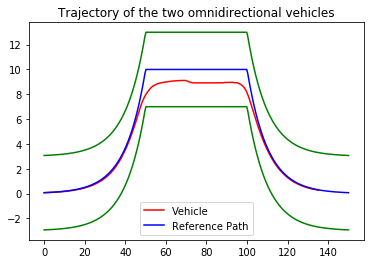

In [10]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [11]:
n = 10
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H10', batch_size = 1000, checkpoint = 'checkpoints/mlp_H10_995.pt') # The NeuralNetwork is defined in bc.py and the network architecture is defined in class mlp

agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
agent.train(num_epoch = 1000)


27416


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch 1] avg_loss: 0.773
[Epoch 6] avg_loss: 0.769
[Epoch 11] avg_loss: 0.768
[Epoch 16] avg_loss: 0.771
[Epoch 21] avg_loss: 0.768
[Epoch 26] avg_loss: 0.767
[Epoch 31] avg_loss: 0.770
[Epoch 36] avg_loss: 0.767
[Epoch 41] avg_loss: 0.768
[Epoch 46] avg_loss: 0.770
[Epoch 51] avg_loss: 0.767
[Epoch 56] avg_loss: 0.768
[Epoch 61] avg_loss: 0.768
[Epoch 66] avg_loss: 0.770
[Epoch 71] avg_loss: 0.768
[Epoch 76] avg_loss: 0.767
[Epoch 81] avg_loss: 0.767
[Epoch 86] avg_loss: 0.769
[Epoch 91] avg_loss: 0.764
[Epoch 96] avg_loss: 0.767
[Epoch 101] avg_loss: 0.769
[Epoch 106] avg_loss: 0.768
[Epoch 111] avg_loss: 0.767
[Epoch 116] avg_loss: 0.765
[Epoch 121] avg_loss: 0.768
[Epoch 126] avg_loss: 0.765
[Epoch 131] avg_loss: 0.769
[Epoch 136] avg_loss: 0.765
[Epoch 141] avg_loss: 0.766
[Epoch 146] avg_loss: 0.767
[Epoch 151] avg_loss: 0.767
[Epoch 156] avg_loss: 0.768
[Epoch 161] avg_loss: 0.766
[Epoch 166] avg_loss: 0.766
[Epoch 171] avg_loss: 0.771
[Epoch 176] avg_loss: 0.765
[Epoch 181] av

In [ ]:

agent_traj = []
batch_size = 1
for i_batch in range(batch_size):
    agent_traj.append([])
    x0 = [[x_path[0][0] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][1] + 3.0 * (2 * random.random() - 1.0), \
              x_path[0][2] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][3] + 3.0 * (2 * random.random() - 1.0)]]  # Initial state.

    N = 300
    n = 10
    for i in range(0, int(N - n) + 1):
        x = []
        for j in x0[0]:
            x.append(j)
        for j in range(len(x_path[i: i + n])):
            for k in range(len(x_path[j + i])):
                x.append(x_path[j + i][k])

        u = agent.run([x])
        agent_traj[-1] = agent_traj[-1] + [[x[:], u[0]]]
        x0 = dynamics.f(x[0:4], u[0], i)

print("Done")

Done


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


The red curve in the plot shows the trajectory of the regression model controller.

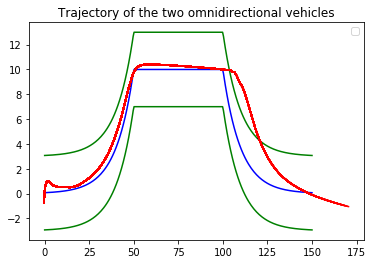

In [14]:
def draw_agent_traj(x_path, agent_traj):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    posx_ = np.asarray(x_path)[:, 0]
    posy_ = np.asarray(x_path)[:, 1]
    plt.plot(posx_, posy_, "b")
    plt.plot(posx_, posy_ + 3.0, 'g')
    plt.plot(posx_, posy_ - 3.0, 'g')

    posx = []
    posy = []
    v = []
    theta = []
    for i in agent_traj:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in i:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(x_path, agent_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

To estimate the loss $L(\delta\theta)$ , one choise is to use L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$. The resulted optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta g(x, \theta)$ can be immensively large. 

The other choise is to use the increase on the original learning model's loss $J_D()$ evaluated on dataset $D$. For simplicity, let's assume that the dataset $D$ is not changed, i.e. $L(\delta\theta) = J_D (\theta + \delta\theta) - J_D(\theta)$. Then, we expand the loss to second order.

\begin{eqnarray}
L(\delta \theta) &=& J_D(\theta + \delta\theta) - J_D(\theta)\\ 
&\approx&
\frac{1}{2}
  \begin{bmatrix}
    1\\
    \delta x\\
    \delta\theta 
  \end{bmatrix}^T 
  \begin{bmatrix}
    1 & 0 & \nabla_\theta J_D(\theta)\\
    0 & 0 & 0\\
    \nabla_\theta J_D(\theta) & 0 & \nabla^2_{\theta, \theta} J_D(\theta) 
  \end{bmatrix}
  \begin{bmatrix}
    1\\
    \delta x\\
    \delta\theta 
  \end{bmatrix}
\end{eqnarray}


It is also possible to solve this problem is to use iLQR by formalizing the problem as follows.

Minimizing the loss w.r.t $\delta\theta$ we have the following.
$$\delta \theta^* = \underset{\delta\theta}{argmin}\ L(\delta \theta) = -\frac{\nabla_\theta J_D(\theta)}{\nabla^2_\theta J_D(\theta)}$$

Obviously, the perturbation on the parameter should be in the same direction of the gradient descent in Newton's method. 

If $\theta$ is already a local optimal solution, then $\nabla^2 J_D(\theta)$ is positive semidefinite and $\nabla J_D(\theta)\delta\theta=0$. Then only the second order term is left. 

\begin{eqnarray}
\underset{\delta\theta}{min}&&\delta\theta^T \nabla J_D(\theta)\delta\theta \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Since the constraints and objective are convex, this is a convex optimization problem.

If $\theta$ is not a local optimal solution but an intermediate model parameter, then the perturbation $\delta \theta$ should remain in the same direction as that of Newton's method. To reduce approximation error, we can add a trust region regularizer as in $\underset{\delta\theta}{min}\ L(\delta\theta) + \lambda ||\delta\theta||^2_2$ where $\lambda$ is a lagrangian variable (constant). This leads to a different search direction and step length.

Naively, $\delta \theta$ can be solved and applied to the learning model parameter after every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient descent step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated sample set for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 

We can also combine the two steps, i.e. perturbing $\theta_{i-1}$ with $\delta\theta_{i-1}$ and updating $\theta_{i-1}\rightarrow \theta_{i}$, since both the search directions contain $\nabla J_D(\theta_{i-1})$ term. Hence, we can use a line search along the direction of $\nabla_\theta J_D(\theta_{i-1})$ with the step length confined by the constraints.

Now let's consider the case where the changes on the parameter leads to a different dataset. It is commonly seen in Reinforcement Learning. The loss for the original learning model is now written as $J(D, \theta)$ and after perturbation it becomes $J(D + \delta D, \theta + \delta \theta)$. Thus, the loss of the perturbation becomes.
\begin{eqnarray}
L(\delta\theta) &=& J(D+\delta D, \theta + \delta\theta) - J(D, \theta)\\
&\approx& \frac{1}{2}
  \begin{bmatrix}
    1\\
    \delta D\\
    \delta\theta 
  \end{bmatrix}^T 
  \begin{bmatrix}
    1 & \nabla_D J(D, \theta) & \nabla_\theta J(D, \theta)\\
    \nabla_D J(D, \theta) & \nabla_{DD} J(D, \theta) & \nabla_{D, \theta} J(D, \theta)\\
    \nabla_\theta J(D, \theta) & \nabla_{\theta, D} J(D, \theta) & \nabla^2_{\theta, \theta} J(D, \theta) 
  \end{bmatrix}
  \begin{bmatrix}
    1\\
    \delta D\\
    \delta\theta 
  \end{bmatrix}
\end{eqnarray}

Minimizing the loss w.r.t $\delta \theta$ we have the follows.
$$\delta\theta^* = \underset{\delta\theta}{argmin} L(\delta D, \delta\theta) = -\nabla_{D, D} J(D,\theta)^{-1}[\nabla_D J(D, \theta) + \nabla_{D, \theta} J(D, \theta)\delta D]$$

To define the perturbation on the dataset $\delta D$, in reinforcement learning, as the data is sampled from the roll out of the learning model, either on-policy or off-policy, $\delta D$ can be represented as a vector of tuples $[\delta x, \delta u, \delta r]$ where $r$ is the reward. However, calculating this closed form of optimal solution can be overwhelming. And it is still remained to be justified whether $\delta D$ should be represented in this way. Therefore, I conservatively suggest using the same dataset.

In [15]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

from bc import *

n = 10
checkpoint = 'checkpoints/mlp_H10_995.pt'
epoch_init = 0
num_epoch = 500
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X) # coo_matrix: a sparse matrix in COOrdinate format.
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

[Epoch 1001] avg_loss: 0.701
(4, 4)
(291, 4, 43254)
(44418, 44418) (44418,) (1160, 44418) (1160,) (2328, 44418) (2328,)
Q (44418, 44418) p (44418, 1)
False d


TypeError: 'q' must be a 'd' matrix with one column

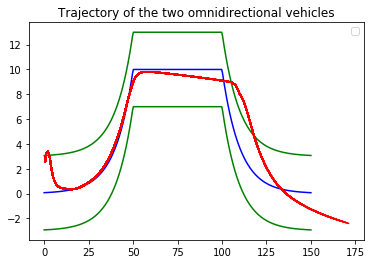

In [16]:
agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H10_MPSC_', \
                      batch_size = 1000, \
                      checkpoint = checkpoint)

agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])

if checkpoint is not None:
    checkpoint = torch.load(checkpoint, map_location=device)
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent.model.eval()
    loss.backward()
    agent.optimizer.step()

(44418, 44418) (44418, 1) (1160, 44418) (1160, 1) (2328, 44418) (2328, 1)
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  3.0031e+00 -3.1492e+03  3e+04  8e-01  3e-10
 1:  2.9007e+00 -1.5525e+03  1e+04  3e-01  2e-10
 2:  1.1530e+01 -1.1696e+03  7e+03  2e-01  5e-10
 3:  5.7908e+01 -7.5875e+02  4e+03  7e-02  1e-09
 4:  9.4861e+01 -1.2663e+02  8e+02  1e-02  7e-10
 5:  1.0201e+02  7.1847e+01  9e+01  1e-03  2e-10
 6:  1.0074e+02  9.4625e+01  2e+01  2e-04  1e-10
 7:  9.9936e+01  9.8621e+01  3e+00  4e-05  7e-11
 8:  9.9777e+01  9.9143e+01  2e+00  2e-05  5e-11
 9:  9.9689e+01  9.9473e+01  5e-01  5e-06  3e-11
10:  9.9675e+01  9.9584e+01  2e-01  1e-06  1e-11
11:  9.9666e+01  9.9646e+01  4e-02  2e-07  6e-12
12:  9.9664e+01  9.9661e+01  6e-03  4e-08  2e-12
13:  9.9664e+01  9.9664e+01  4e-04  2e-09  9e-13
14:  9.9664e+01  9.9664e+01  9e-06  4e-11  7e-13
Optimal solution found.
QP solved
Model prameter updated
[Epoch 1006] avg_loss: 1.771
[Epoch 1001] avg_loss: 0.701
(4, 4)
(

TypeError: 'q' must be a 'd' matrix with one column

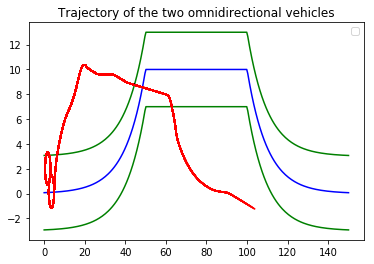

(44418, 44418) (44418, 1) (1160, 44418) (1160, 1) (2328, 44418) (2328, 1)
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  2.4261e+00 -3.0648e+03  4e+04  8e-01  3e-08
 1:  4.3071e+00 -1.8928e+03  2e+04  4e-01  2e-08
 2:  4.8104e+00 -6.2498e+02  2e+04  4e-01  2e-08


KeyboardInterrupt: 

In [22]:
x00 = [[x_path[0][0] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][1] + 3.0 * (2 * random.random() - 1.0), \
              x_path[0][2] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][3] + 3.0 * (2 * random.random() - 1.0)]]  # Initial state.

for epoch in range(epoch_init, num_epoch + epoch_init):  # loop over the dataset multiple times
    dataloader = data_utils.DataLoader(agent.dataset, batch_size = agent.batch_size, shuffle = True)
    running_loss = 0.0
    
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.float().to(agent.device), labels.float().to(agent.device)
        inputs.requires_grad = True
        
        agent.optimizer.zero_grad()
        
        outputs = agent.model(inputs)
        outputs = torch.reshape(outputs, (outputs.size()[0], agent.output_size))
        
        loss = agent.criterion(outputs, labels)
        loss.backward()
    
        # print statistics

  
        running_loss += loss.item()
        agent.optimizer.step()
        #agent.run()
    if epoch % 5 == 0:
        print('[Epoch %d] avg_loss: %.3f' % (epoch + 1, running_loss/len(dataloader)))
        torch.save({'epoch': epoch, \
                    'model_state_dict': agent.model.state_dict(), \
                    'optimizer_state_dict': agent.optimizer.state_dict(), \
                    'loss': loss}, str('checkpoints/' + str(agent.model_name) + '_' + str(epoch) + '.pt'))
        x0 = x00

        N = 300
        n = 10
        agent_traj = []
        
        f_x = np.empty((N -n + 1, dynamics.state_size, dynamics.state_size))
        f_u = np.empty((N -n + 1, dynamics.state_size, dynamics.action_size))
        g_x = np.empty((N -n + 1, dynamics.action_size, dynamics.state_size, ))
        g_theta = np.empty((N -n + 1, dynamics.action_size, agent.num_parameters(agent.model)))
        '''
        print(f_x.shape)
        print(f_u.shape)
        print(g_x.shape)
        print(g_theta.shape)
        '''
        
        F_x = np.empty((N - n + 1, dynamics.state_size, dynamics.state_size))
        F_theta = np.empty((N - n + 1, dynamics.state_size, agent.num_parameters(agent.model)))
        
        # Search every time step
        for i in range(int(N - n) + 1):
            # Generate (state, control) pairs
            x = []
            for j in x0[0]:
                x.append(j)
            for j in range(len(x_path[i: i + n])):
                for k in range(len(x_path[j + i])):
                    x.append(x_path[j + i][k])
            x = np.asarray([x])
            x = torch.tensor(x, requires_grad = True).float().to(agent.device)
            
            agent.optimizer.zero_grad()
            u = agent.model(x)
            
            
            for j in range(dynamics.action_size):
                # Get gradient w.r.t input x[0:4] <<<< g_x
                g_x[i, j, :] = torch.autograd.grad(u[0, j], x, retain_graph = True\
                                                  )[0].cpu().numpy()[0, 0:dynamics.state_size]
                
                # Get gradient w.r.t model parameters theta <<<< g_theta
                torch.autograd.backward(u[0, j], retain_graph = True)
                k = 0
                for theta in agent.model.parameters():
                    g_theta_ = theta.grad.data.flatten() 
                    g_theta[i, j, k : k + g_theta_.size()[0]] = g_theta_.cpu().numpy()
                    k += g_theta_.size()[0]
            
            
            x = x.detach().cpu().numpy()
            u = u.detach().cpu().numpy()
            
            # Get dynamics w.r.t x <<<< f_x         
            f_x[i] = dynamics.f_x(x[0, 0:4], u[0], i)
            
            # Get dynamics w.r.t u <<<< f_u
            f_u[i] = dynamics.f_u(x[0, 0:4], u[0], i)
            
            # Record the trajectory
            agent_traj.append([x[0], u[0]])
                              
            # Find next state
            x0 = dynamics.f(x[0, 0:4], u[0], i)
            
            # Calculate f_x + f_u g_x
            F_x[i] = f_x[i] + f_u[i].dot(g_x[i])
            # Calculate f_u g_theta
            F_theta[i] = f_u[i].dot(g_theta[i])
        
        draw_agent_traj(x_path, [agent_traj])
        
        # Define QP objective Q, p
        Q = np.eye(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))
        q = np.zeros((dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model), 1))
        
        # Define QP constraint Ax = b, Gx <= h
        A = np.zeros((dynamics.state_size * (N - n), \
                      dynamics.state_size * (N - n + 1) \
                      + agent.num_parameters(agent.model)))
        
        b = np.zeros((dynamics.state_size * (N - n), 1))
        G = np.zeros((2 * dynamics.state_size * (N - n + 1), \
                      dynamics.state_size * (N - n + 1)\
                      + agent.num_parameters(agent.model)))
        h = np.zeros((2 * dynamics.state_size * (N - n + 1), 1))
        
        for i in range(0, N - n + 1):
            x = agent_traj[i][0]
            u = agent_traj[i][1]
            
            if i <= N - n - 1:
                A[dynamics.state_size * i : dynamics.state_size * (i + 1), \
                  dynamics.state_size * i : dynamics.state_size * (i + 1)] = F_x[i, :]
                A[dynamics.state_size * i : dynamics.state_size * (i + 1), \
                  dynamics.state_size * (i + 1) : dynamics.state_size * (i + 2)] = - np.eye(dynamics.state_size)
                A[dynamics.state_size * i : dynamics.state_size * (i + 1),\
                  -agent.num_parameters(agent.model) : ] = F_theta[i, :]
                
            G[dynamics.state_size * 2 * i + 1, dynamics.state_size * i + 1] = 1.0
            G[dynamics.state_size * (2 * i + 1) + 1, dynamics.state_size * i + 1] =  - 1.0
            
            if i != 0:
                h[dynamics.state_size * 2 * i + 1] = nominal(x[0])[0] - x[1]
                h[dynamics.state_size * (2 * i + 1) + 1] = x[1] - nominal(x[0])[1]
        
            for j in range(dynamics.state_size):
                Q[i * dynamics.state_size + j] = 0.0
        
        
        print(Q.shape, q.shape, A.shape, b.shape, G.shape, h.shape)
        
        Q = numpy_sparse_to_spmatrix(Q)
        q = matrix(q)
        A = numpy_sparse_to_spmatrix(A)
        b = matrix(b)
        G = numpy_sparse_to_spmatrix(G)
        h = numpy_sparse_to_spmatrix(h)
        p = p.T
        print("Q", Q.size, "p", p.size) # `shape` for np.array, `size` for cvxopt.base.spmatrix
        print(isinstance(p,matrix),p.typecode)
        # sol=solvers.qp(Q, p, G, h, A, b) # get error "TypeError: 'q' must be a 'd' matrix with one column"
        sol=solvers.qp(Q, p, G, h, A, b)
        delta_theta = sol['x']
        h = matrix(h)
        print("Starting solving QP")
        sol=solvers.qp(Q, q, G, h, A, b)
        #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
        delta_theta = list(sol['x'])

        pickle.dump(delta_theta, open('model_parameter_perturbation_' + str(i) + '.p', 'wb'))
        print('QP solved')
        print('Model prameter updated')
        
        i = dynamics.state_size * (N - n + 1)
        for theta in agent.model.parameters():
            theta.data += torch.FloatTensor(delta_theta[i: i + theta.data.numel()]).reshape(theta.data.size()).to(agent.device)
            i += theta.data.numel()
        
